# Data Cleaning, Feature Engineering, EDA Notebook

In [1]:
# Standard imports
import numpy as np
import pandas as pd

# Data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scotus class object
from scotus_class import scotus

In [2]:
df = pd.read_csv('scotus_rulings.csv', index_col=0)

## Clean data and engineer metric
As seen by the sample rows, a justice can hold multiple opinions on a case.  They can simultaneously agree with the decision of the majority opinion but hold a separate reasoning(s) on the ruling (filing a concurrence).  With 1 being agreement and 2 filing a concurrence (and similarly 4 being dissent and 3 filing a concurrence/dissent).  The metric used here tries to capture the difference between those opinions by finding the mean of a justice's opinion (while removing filing multiple concurrences/dissents in a specific case).

In [3]:
# Map code string to metric function
def string_2_ints(s):    
    # Special case 'X' is no vote
    if s is np.nan:
        return np.nan
    if s == 'X':
        return np.nan
    
    # Split and remove non-integers, simplify to either majority or dissent
    nums = []
    for x in set(list(s)):
        try:
            nums.append(int(x))
        except:
            continue
    
    return np.mean(nums)

In [4]:
adj_df = pd.DataFrame(np.vectorize(string_2_ints)(df), index=df.index)

In [5]:
adj_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647
Alito,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,3.0,1.0,1.0,1.0,2.0,1.0,1.5,1.0
Breyer,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.5,...,1.0,1.0,1.0,1.0,2.0,3.0,1.0,4.0,4.0,4.0
Ginsburg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.5,...,1.0,1.0,1.0,1.0,2.0,3.0,1.0,4.0,4.0,1.0


## Scotus Rulings Class Object
A class object was created in order to encapsulate data in the file ```scotus_class.py```.  The methods return various forms of data including courts of justices (as old ones retire and new ones are appointed) allowing for easy comparisons for EDA and in a dashboard.

In [6]:
scotus = scotus(adj_df)

## EDA

### Mean Level of Dissent
Justice's opinions on cases were coded such that:
- 1 = Wrote or Joined Majority
- 2 = Wrote or Joined a Concurrence
- 3 = Wrote or Joined a Concurrence/Dissent
- 4 = Wrote or Joined a Dissent

The graph below illustrates the mean opinion of a justice.  A greater mean opinion equates to a greater tendency to have a differing opinion than the majority opinion.

In [60]:
fig = px.bar(pd.DataFrame(adj_df.mean(axis=1)).reset_index(), x='index', y=0, range_y=(1, 2))
fig.update_layout(
    title='Justices by Mean Opinion',
    xaxis_title='Justices',
    yaxis_title='Mean Level of Dissent',
    xaxis={'categoryorder':'total descending'},
)

### Similarity Matrix
The plot below illustrates the cosine similarity between justices

In [7]:
sim_mat = pd.DataFrame(scotus.sim_matrix(), index=adj_df.index, columns=adj_df.index)

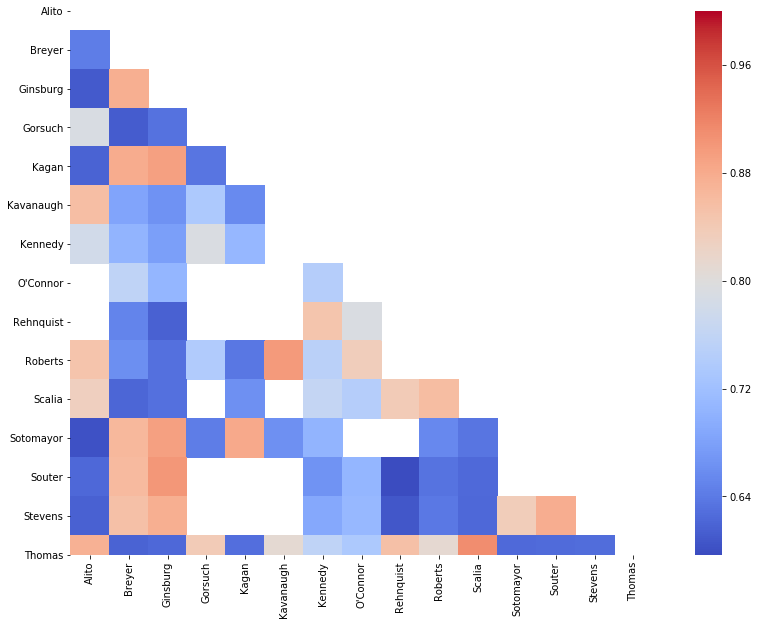

In [8]:
plt.figure(figsize=(15,10))
mask = np.zeros(sim_mat.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(sim_mat, cmap='coolwarm', mask=mask, square=True)
plt.show()

### Cosine Similarity as a Network Graph

In [64]:
sim_mat.describe()

,Alito,Breyer,Ginsburg,Gorsuch,Kagan,Kavanaugh,Kennedy,O'Connor,Rehnquist,Roberts,Scalia,Sotomayor,Souter,Stevens,Thomas
count,13.000000,15.000000,15.000000,10.000000,11.000000,9.000000,14.000000,10.000000,9.000000,14.000000,13.000000,12.000000,11.000000,12.000000,15.000000
mean,0.745969,0.752453,0.748627,0.742210,0.745345,0.774189,0.755893,0.772790,0.755967,0.756800,0.749462,0.750025,0.737927,0.746350,0.755987
std,0.133091,0.125417,0.138404,0.120506,0.138954,0.124175,0.086268,0.089327,0.143286,0.119938,0.128776,0.135542,0.143541,0.134911,0.126557
min,0.602200,0.612500,0.610000,0.612500,0.617500,0.655600,0.665000,0.706400,0.596900,0.630200,0.621100,0.602200,0.596900,0.606800,0.618500
25%,0.617500,0.646400,0.630500,0.638000,0.636200,0.663600,0.703150,0.715925,0.616600,0.642050,0.630800,0.641475,0.624950,0.626550,0.627000
50%,0.781100,0.703100,0.678400,0.736650,0.663000,0.734600,0.746900,0.743750,0.792600,0.744500,0.744000,0.682500,0.665000,0.699750,0.756400
75%,0.849300,0.863550,0.884350,0.792900,0.880750,0.857900,0.776550,0.783775,0.847500,0.845300,0.839000,0.869525,0.869950,0.859625,0.846800
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
# Create nodes
nodes = scotus.justices
l = len(nodes)

In [31]:
# Create edges, tuple = (justice A, justice B, cosine similarity)
edges = []
for i in range(l):
    for j in range(i+1, l):
        if str(sim_mat.iloc[i][j]) != 'nan':
            tup = (sim_mat.iloc[i].name, sim_mat.iloc[i].index[j], sim_mat.iloc[i][j])
            edges.append(tup)

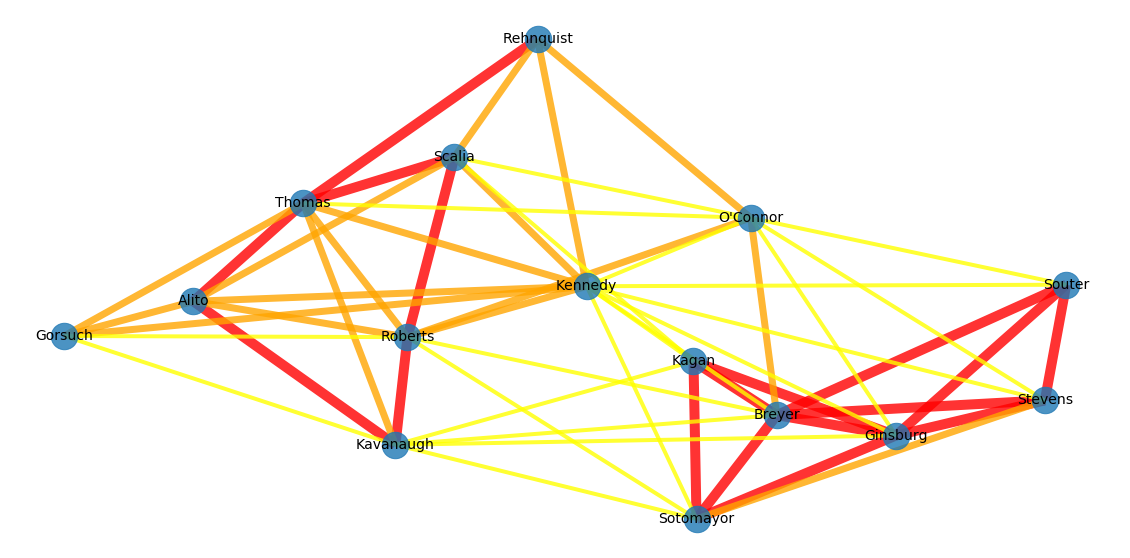

In [69]:
# Instantiate graph object
fig = plt.figure(figsize=(20,10))
G = nx.Graph()

# Add edges to graph
for edge in edges:
    if edge[2] > 0.65:
        G.add_edge(edge[0], edge[1], weight=edge[2])

# Create line weights
el = [ (u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.85 ]
eml = [ (u, v) for (u, v, d) in G.edges(data=True) if (d['weight'] > 0.75) and (d['weight'] <= 0.85) ]
em = [ (u, v) for (u, v, d) in G.edges(data=True) if (d['weight'] > 0.65) and (d['weight'] <= 0.75) ]
#

# Postions of nodes and edges
pos = nx.spring_layout(G)

nl = [ G.nodes(data=True) ]
nml = G.nodes(data=True)
nm =

# Plot Nodes
nx.draw_networkx_nodes(G, pos, node_size=700, alpha=0.8)

# Plot Edges
nx.draw_networkx_edges(G, pos, edgelist=el, width=10, edge_color='r', alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=eml, width=7, edge_color='orange', alpha=0.8)
nx.draw_networkx_edges(G, pos, edgelist=em, width=4, edge_color='yellow', alpha=0.8)

# Add Justice Labels
nx.draw_networkx_labels(G, pos, font_size=14, font_family='sans-serif')

plt.axis('off')
plt.show()

In [72]:
G.nodes(data=True)

NodeDataView({'Alito': {}, 'Gorsuch': {}, 'Kavanaugh': {}, 'Kennedy': {}, 'Roberts': {}, 'Scalia': {}, 'Thomas': {}, 'Breyer': {}, 'Ginsburg': {}, 'Kagan': {}, "O'Connor": {}, 'Sotomayor': {}, 'Souter': {}, 'Stevens': {}, 'Rehnquist': {}})

In [73]:
G.edges(data=True)

EdgeDataView([('Alito', 'Gorsuch', {'weight': 0.7917}), ('Alito', 'Kavanaugh', {'weight': 0.8579}), ('Alito', 'Kennedy', {'weight': 0.7811}), ('Alito', 'Roberts', {'weight': 0.8493}), ('Alito', 'Scalia', {'weight': 0.8308}), ('Alito', 'Thomas', {'weight': 0.8738}), ('Gorsuch', 'Kavanaugh', {'weight': 0.7346}), ('Gorsuch', 'Kennedy', {'weight': 0.7933}), ('Gorsuch', 'Roberts', {'weight': 0.7387}), ('Gorsuch', 'Thomas', {'weight': 0.8388}), ('Kavanaugh', 'Breyer', {'weight': 0.6849}), ('Kavanaugh', 'Ginsburg', {'weight': 0.6636}), ('Kavanaugh', 'Kagan', {'weight': 0.6556}), ('Kavanaugh', 'Roberts', {'weight': 0.8989}), ('Kavanaugh', 'Sotomayor', {'weight': 0.6617}), ('Kavanaugh', 'Thomas', {'weight': 0.8105}), ('Kennedy', 'Breyer', {'weight': 0.7031}), ('Kennedy', 'Ginsburg', {'weight': 0.6784}), ('Kennedy', 'Kagan', {'weight': 0.7081}), ('Kennedy', "O'Connor", {'weight': 0.7435}), ('Kennedy', 'Rehnquist', {'weight': 0.8475}), ('Kennedy', 'Roberts', {'weight': 0.7503}), ('Kennedy', 'Scal